# Phase 1: Dataset Analysis & EDA
## Active Fire Detection in Landsat-8 Imagery

### Literature Review & Baseline Models
We reference the **ActiveFire** dataset (Pereira et al., 2020) and compare against standard U-Net baselines.

| Paper / Model | Key Contribution | Architecture |
| :--- | :--- | :--- |
| **Pereira et al. (2020)** | ActiveFire Dataset (150k patches). Benchmarked U-Net. | U-Net (VGG-like) |
| **Schroeder et al. (2016)** | Standard algorithm for Landsat-8 fire detection. | Threshold-based (Handcrafted) |
| **Murphy et al. (2016)** | Contextual fire detection algorithm. | Threshold-based (Handcrafted) |
| **Oktay et al. (2018)** | Attention U-Net. | Attention Gates + U-Net |
| **He et al. (2016)** | ResNet (Residual Learning). | Deep CNN Backbone |

**Our Proposed Approach:**
*   **Architecture:** **ResNet34-UNet**. We replace the standard U-Net encoder with a pre-trained ResNet34. This leverages transfer learning for robust feature extraction (texture, edges) while the U-Net decoder recovers spatial resolution.
*   **Loss Function:** **Dice + Focal Loss**. To handle the extreme class imbalance (fire < 0.1% of pixels).
*   **Input:** **10-Channel Multispectral**. We utilize the full spectral resolution of Landsat-8, not just RGB.


In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tiff
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("Libraries imported successfully.")


Libraries imported successfully.


In [2]:
# 3. Data Discovery & Pairing
# Scanning North America and South America datasets.

dataset_root = "/Users/basanthyajman/Documents/Deep Learning/Project/dataset"
subdirs = ["North_America1", "North_America2", "South_America"]

all_images = {}
all_masks = {}

print("Scanning directories...")
for subdir in subdirs:
    full_path = os.path.join(dataset_root, subdir)
    if not os.path.exists(full_path):
        continue
    
    files = glob.glob(os.path.join(full_path, "*.tif"))
    for f in files:
        basename = os.path.basename(f)
        if "_RT_voting_p" in basename:
            id_key = basename.replace("_voting", "")
            all_masks[id_key] = f
        elif "_RT_p" in basename and "voting" not in basename and "intersection" not in basename:
            all_images[basename] = f

common_ids = set(all_images.keys()).intersection(set(all_masks.keys()))
print(f"Total Images Found: {len(all_images)}")
print(f"Total Masks Found: {len(all_masks)}")
print(f"Paired Samples: {len(common_ids)}")

data = []
for key in sorted(list(common_ids)):
    data.append({
        "image_path": all_images[key],
        "mask_path": all_masks[key]
    })

df = pd.DataFrame(data)
print(df.head())


Scanning directories...


Total Images Found: 27760
Total Masks Found: 14815
Paired Samples: 14815
                                          image_path  \
0  /Users/basanthyajman/Documents/Deep Learning/P...   
1  /Users/basanthyajman/Documents/Deep Learning/P...   
2  /Users/basanthyajman/Documents/Deep Learning/P...   
3  /Users/basanthyajman/Documents/Deep Learning/P...   
4  /Users/basanthyajman/Documents/Deep Learning/P...   

                                           mask_path  
0  /Users/basanthyajman/Documents/Deep Learning/P...  
1  /Users/basanthyajman/Documents/Deep Learning/P...  
2  /Users/basanthyajman/Documents/Deep Learning/P...  
3  /Users/basanthyajman/Documents/Deep Learning/P...  
4  /Users/basanthyajman/Documents/Deep Learning/P...  


Sampling 100 images for spectral signature analysis...


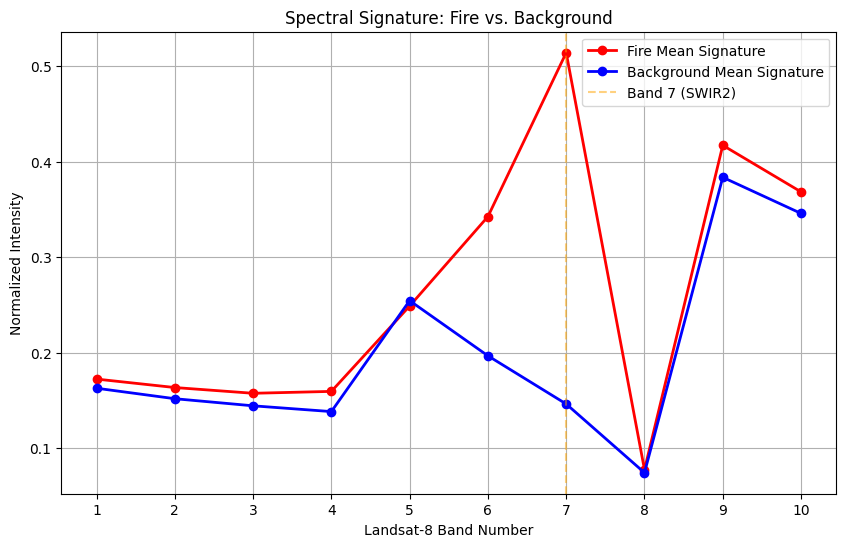

Observation: Fire should show a distinct peak in SWIR bands (B6, B7) compared to background.


In [ ]:
# Domain Analysis: Spectral Signatures
# Plotting the Mean Intensity of Fire vs. Background across all 10 bands.

def plot_spectral_signatures(df, num_samples=100):
    fire_samples = []
    bg_samples = []
    
    print(f"Sampling {num_samples} images for spectral signature analysis...")
    indices = np.random.choice(len(df), min(len(df), num_samples), replace=False)
    
    for idx in indices:
        try:
            img = tiff.imread(df.iloc[idx]['image_path'])
            mask = tiff.imread(df.iloc[idx]['mask_path'])
            
            if img.ndim == 3 and img.shape[0] <= 11:
                img = np.transpose(img, (1, 2, 0))
            
            # Normalize to [0, 1] for fair comparison across images
            img = img.astype(np.float32) / 65535.0 # Assuming 16-bit
            
            img_flat = img.reshape(-1, img.shape[2])
            mask_flat = mask.flatten()
            
            fire_pixels = img_flat[mask_flat > 0]
            bg_pixels = img_flat[mask_flat == 0]
            
            if len(fire_pixels) > 0:
                # Take mean of fire pixels in this image
                fire_samples.append(np.mean(fire_pixels, axis=0))
                
            if len(bg_pixels) > 0:
                # Take mean of background pixels (subsampled)
                bg_sub = bg_pixels[np.random.choice(len(bg_pixels), min(len(bg_pixels), 1000), replace=False)]
                bg_samples.append(np.mean(bg_sub, axis=0))
                
        except: pass
        
    if not fire_samples:
        print("No fire pixels found.")
        return

    fire_mean = np.mean(np.array(fire_samples), axis=0)
    bg_mean = np.mean(np.array(bg_samples), axis=0)
    
    bands = range(1, len(fire_mean) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(bands, fire_mean, 'r-o', label='Fire Mean Signature', linewidth=2)
    plt.plot(bands, bg_mean, 'b-o', label='Background Mean Signature', linewidth=2)
    
    plt.title("Spectral Signature: Fire vs. Background")
    plt.xlabel("Landsat-8 Band Number")
    plt.ylabel("Normalized Intensity")
    plt.xticks(bands)
    plt.grid(True)
    plt.legend()
    
    # Annotate key bands
    # B5=NIR, B6=SWIR1, B7=SWIR2 (Key for fire)
    plt.axvline(x=7, color='orange', linestyle='--', alpha=0.5, label='Band 7 (SWIR2)')
    plt.legend()
    plt.show()
    print("Observation: Fire should show a distinct peak in SWIR bands (B6, B7) compared to background.")

if len(df) > 0:
    plot_spectral_signatures(df)


/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/opt/miniconda3/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


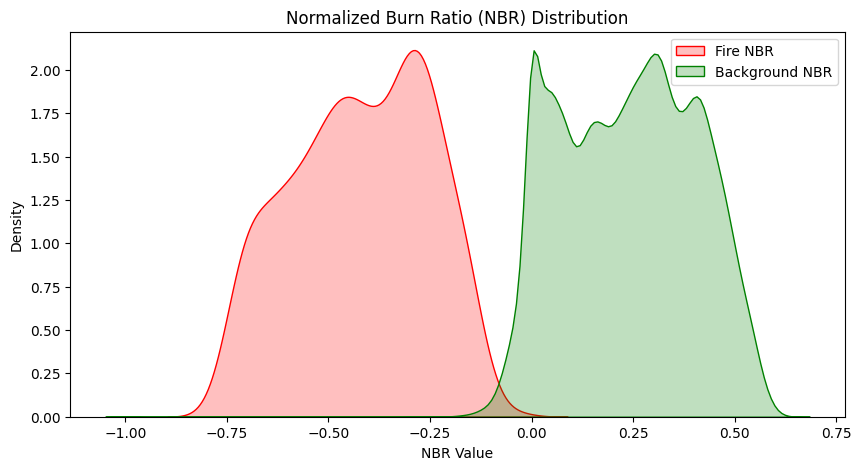

In [4]:
# 5. Domain Analysis: Spectral Indices (NBR, NDVI)
# NBR (Normalized Burn Ratio) = (NIR - SWIR2) / (NIR + SWIR2)
# NDVI (Vegetation Index) = (NIR - Red) / (NIR + Red)
# Fire usually has LOW NBR (negative) and LOW NDVI (vegetation burned).

def analyze_indices(df, num_samples=100):
    fire_nbr = []
    bg_nbr = []
    
    indices = np.random.choice(len(df), min(len(df), num_samples), replace=False)
    
    for idx in indices:
        try:
            img = tiff.imread(df.iloc[idx]['image_path'])
            mask = tiff.imread(df.iloc[idx]['mask_path'])
            
            if img.ndim == 3 and img.shape[0] <= 11:
                img = np.transpose(img, (1, 2, 0))
                
            img = img.astype(np.float32)
            
            # Band 5 (NIR) is index 4, Band 7 (SWIR2) is index 6
            nir = img[:, :, 4]
            swir2 = img[:, :, 6]
            
            # Avoid div by zero
            denom = nir + swir2 + 1e-6
            nbr = (nir - swir2) / denom
            
            mask_flat = mask.flatten()
            nbr_flat = nbr.flatten()
            
            fire_nbr.extend(nbr_flat[mask_flat > 0])
            
            # Subsample background
            bg_indices = np.where(mask_flat == 0)[0]
            if len(bg_indices) > 0:
                chosen = np.random.choice(bg_indices, size=min(len(bg_indices), 1000), replace=False)
                bg_nbr.extend(nbr_flat[chosen])
                
        except: pass
        
    plt.figure(figsize=(10, 5))
    sns.kdeplot(fire_nbr, label='Fire NBR', fill=True, color='red')
    sns.kdeplot(bg_nbr, label='Background NBR', fill=True, color='green')
    plt.title("Normalized Burn Ratio (NBR) Distribution")
    plt.xlabel("NBR Value")
    plt.legend()
    plt.show()

if len(df) > 0:
    analyze_indices(df)


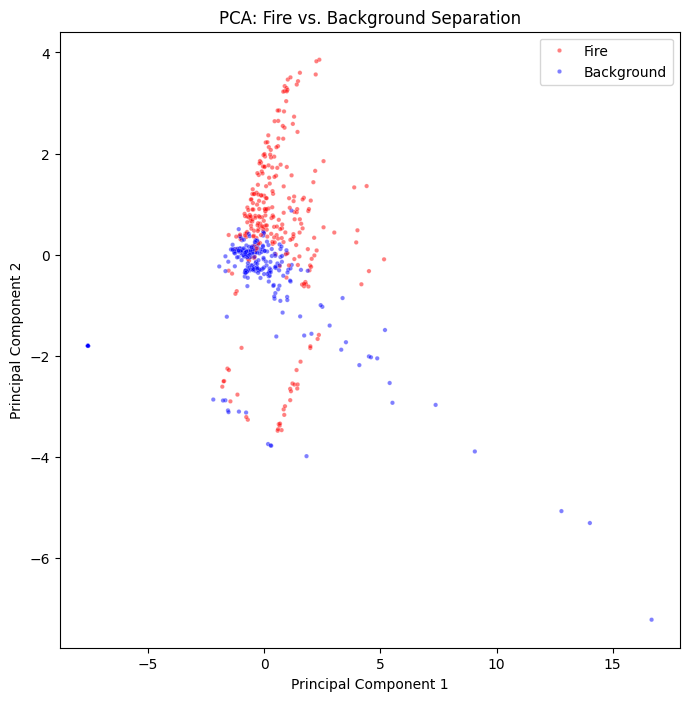

In [5]:
# 6. Dimensionality Reduction: PCA
# Can we separate Fire/Non-Fire in a lower dimensional space?

def plot_pca(df, num_samples=50):
    pixels = []
    labels = []
    
    indices = np.random.choice(len(df), min(len(df), num_samples), replace=False)
    
    for idx in indices:
        try:
            img = tiff.imread(df.iloc[idx]['image_path'])
            mask = tiff.imread(df.iloc[idx]['mask_path'])
            
            if img.ndim == 3 and img.shape[0] <= 11:
                img = np.transpose(img, (1, 2, 0))
            
            img = img.astype(np.float32) / 65535.0
            img_flat = img.reshape(-1, img.shape[2])
            mask_flat = mask.flatten()
            
            fire_mask = mask_flat > 0
            
            if np.sum(fire_mask) > 0:
                # Take all fire pixels
                pixels.append(img_flat[fire_mask])
                labels.extend(['Fire'] * np.sum(fire_mask))
                
                # Take equal number of background pixels
                bg_indices = np.where(~fire_mask)[0]
                chosen = np.random.choice(bg_indices, size=np.sum(fire_mask), replace=False)
                pixels.append(img_flat[chosen])
                labels.extend(['Background'] * len(chosen))
        except: pass
        
    if not pixels: return
    
    X = np.vstack(pixels)
    y = np.array(labels)
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(StandardScaler().fit_transform(X))
    
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette={'Fire': 'red', 'Background': 'blue'}, alpha=0.5, s=10)
    plt.title("PCA: Fire vs. Background Separation")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

if len(df) > 0:
    plot_pca(df)


Visualizing samples with fire...


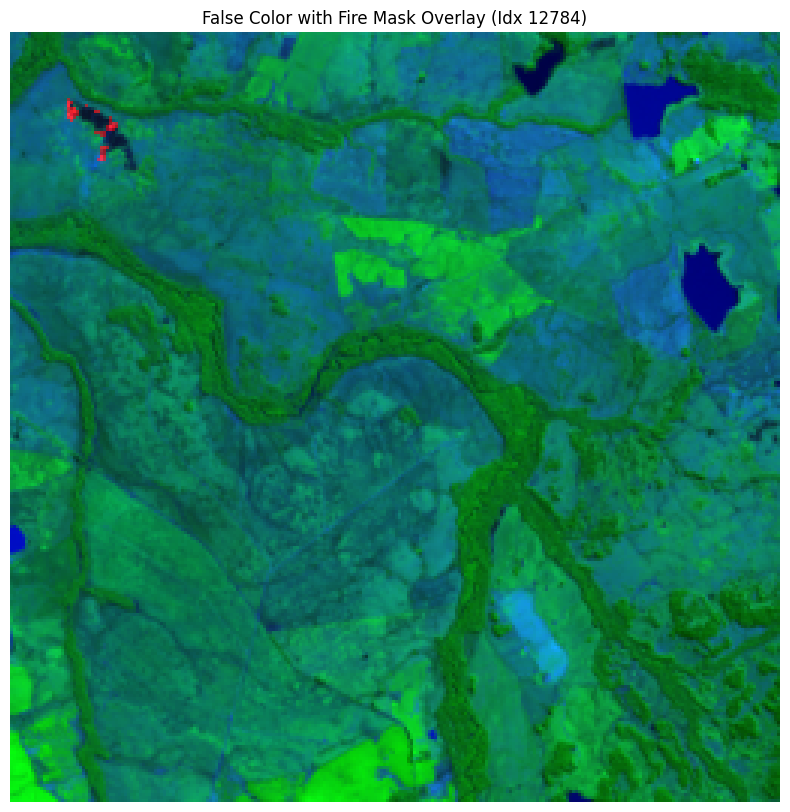

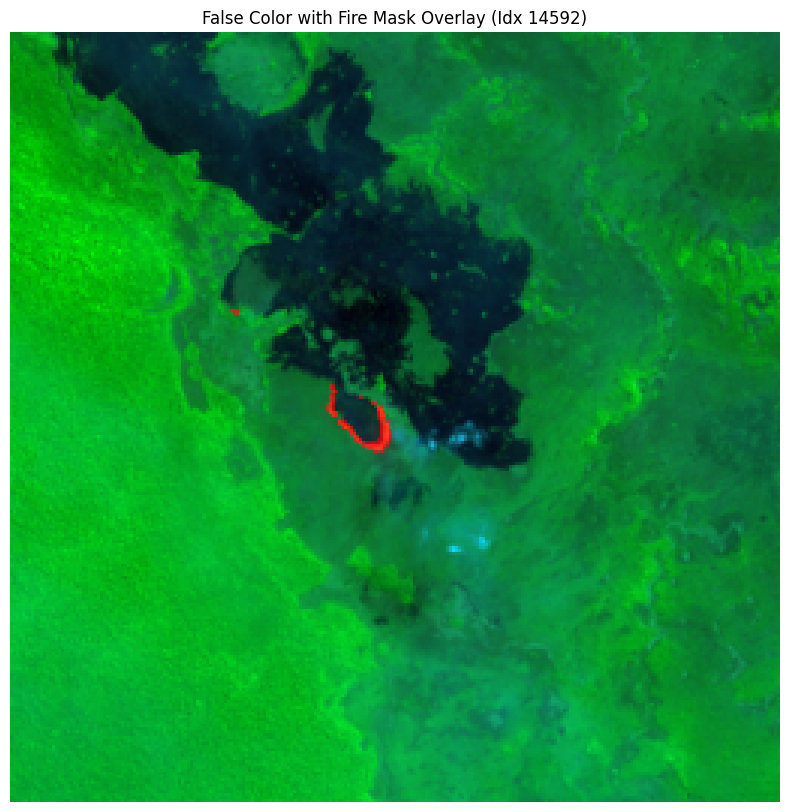

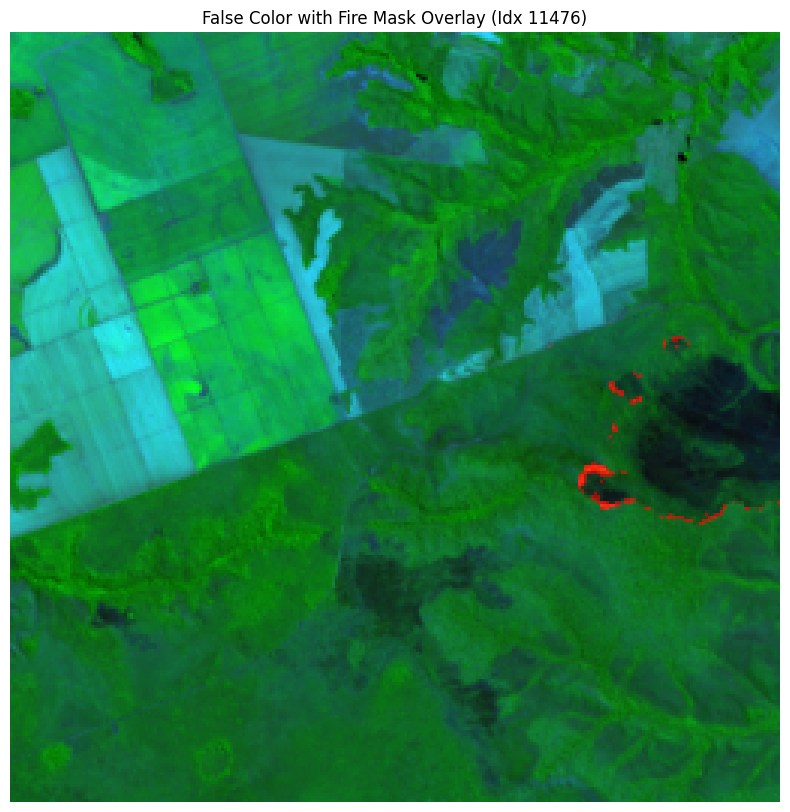

In [6]:
# 7. Visualization: False Color + Fire Mask Overlay

def visualize_overlay(index):
    row = df.iloc[index]
    img_path = row['image_path']
    msk_path = row['mask_path']
    
    try:
        image = tiff.imread(img_path)
        mask = tiff.imread(msk_path)
        
        def normalize(band):
            return (band - band.min()) / (band.max() - band.min() + 1e-8)

        if image.ndim == 3 and image.shape[0] <= 11:
            image = np.transpose(image, (1, 2, 0))
        
        # False Color: SWIR2 (B7), NIR (B5), Red (B4)
        if image.shape[2] >= 7:
            r = normalize(image[:, :, 6])
            g = normalize(image[:, :, 4])
            b = normalize(image[:, :, 3])
            rgb = np.dstack((r, g, b))
        else:
            rgb = normalize(image[:, :, 0])

        plt.figure(figsize=(10, 10))
        plt.title(f"False Color with Fire Mask Overlay (Idx {index})")
        plt.imshow(rgb, cmap='gray' if rgb.ndim==2 else None)
        
        mask_rgba = np.zeros((mask.shape[0], mask.shape[1], 4))
        mask_rgba[mask > 0] = [1, 0, 0, 0.5] 
        
        plt.imshow(mask_rgba)
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error: {e}")

print("Visualizing samples with fire...")
fire_indices = []
for i in range(len(df)):
    try:
        # Quick check without loading full image if possible, but we need to load mask
        # Just sample random ones and check
        if len(fire_indices) >= 3: break
        idx = np.random.randint(0, len(df))
        m = tiff.imread(df.iloc[idx]['mask_path'])
        if np.sum(m) > 10:
            fire_indices.append(idx)
    except: pass

for idx in fire_indices:
    visualize_overlay(idx)


In [7]:
# 8. Data Splitting
train_df, test_val_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.33, random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)


Train: 10370, Val: 2978, Test: 1467
